# Project I: Parameter estimation for a toy model of an effective field theory
## Learning from data [TIF285], Chalmers, Fall 2022

Last revised: 3-Sep-2022 by Christian Forssén [christian.forssen@chalmers.se]

## Instructions

- See deadline on the course web page
- This project is performed in groups of two students. 
- The second part of the project is optional. See examination rules on the course web page.
- Hand-in your written report and your solution source code via Canvas.
- Students are allowed to discuss together and help each other when working on the projects. However, every student must understand and be able to explain their submitted solutions. Plagiarism (of text and/or code) is not allowed (submissions will be both manually and automatically monitored).

### Written report
- Page limit: 6 pages (excluding title page and list of references). 3 extra pages are allowed when doing also the optional extra task.
- Give a short description of the nature of the problem and the methods you have used.
- Include your results either in figure or tabular form. All tables and figures should have relevant captions and labels on the axes.
- Try to give an interpretation of you results.
- Upload the source code of your program as a separate file (.ipynb or .py). Comment your program properly.

## Main task
The overall project goal is to reproduce various results in a paper: [*Bayesian parameter estimation for effective field theories*](https://arxiv.org/abs/1511.03618) by Sarah Wesolowski, et al.  It's a long paper, so don't try to read all of it!  We'll guide you to the important parts. Sec. II of the paper is the most relevant, but you don't need to understand all of it. 

The paper uses a toy model to simulate an effective field theory (EFT), namely a Taylor series of some specified function. A specific aim is to present guidelines for parameter estimation in the situation where you have some knowledge of the model that can be used in a Bayesian way. We will not discuss the EFT concept in any detail, but will just mention that it is a type of approximation, or effective theory, for a more fundamental (underlying) physical theory. An EFT starts from the relevant degrees of freedom to describe physical phenomena occurring at a chosen length scale or energy scale, while not resolving substructure and degrees of freedom at shorter distances (or, equivalently, at higher energies). 

In our case, the function
$$
g(x) = \left(\frac12 + \tan\left(\frac{\pi}{2}x\right)\right)^2
$$
represents the true, underlying theory.  Its Taylor series at $x=0$ is
$$
g(x) = 0.25 + 1.57 x + 2.47 x^2 + 1.29 x^3 + \cdots
$$
where the expansion parameters are known in this toy example (since we know the underlying theory), but would not be in a real situation.

Our "effective theory" then corresponds to the expansion
$$
g_{\rm th}(x) \equiv \sum_{i=0}^k a_i x^i,
$$
where $a_i$ are the parameters. For an EFT, these are sometimes known as low-energy constants (LECs).

Your general task is to fit the parameters $a_i$, up to some truncation order $k$, using a Bayesian approach, and analyze the results. 

* **Your specific goal is to reproduce and interpret Figure 1 on page 6 of the arXiv preprint. This figure shows joint pdfs for the EFT parameters using two different priors. One of these priors encapsulates the physics expectation that the parameters should be of "natural" size (order one).**
* **A secondary goal is to reproduce Figs. 3 and 4 that show predictions of the inferred EFT with error bands. You can either use $k=k_\mathrm{max}=3$ as in the first task, or $k=k_\mathrm{max}=4$ as in the preprint.** 

You should use emcee to sample the joint pdfs and you should use corner to make plots.

### Learning goals:
* Apply and extend the Bayesian parameter estimation ideas and techniques from the course.
* This a less-guided set of tasks and you will have to put together ideas and tools we've discussed.
* Explore the impact of control features:  dependence on how much data is used and how precise it is; apply an *informative* prior.
* Learn about some diagnostics for Bayesian parameter estimation.
* Try out sampling on a controlled problem.

### Suggestions for how to proceed:
* Follow the lead of the exercise notebooks.
* Load the data set that was used in the paper: [D1_c_5.dat](https://arxiv.org/src/1511.03618v3/anc/D1_c_5.dat). The three columns correspond respectively to $x_j$, the measured data $d(x_j) \equiv d_j$ and the error in terms of a standard deviation $\sigma_j$.
* Define functions for the two choices of prior: a wide uniform prior, e.g. $|a_i|<100$, and a Gaussian naturalness prior given by Eq. (24) with $\bar{a}=5$. Use the log prior.
* Define a function for the likelihood (Eq. 9). It will require the chi-squared measure. Use the log likelihood.
* Call emcee to sample the posteriors. 
* Use corner to create plots.  You can read the answers for the tables from the corner plots.
* Don't try to do too much in your code at first (start with a low order). 
* Generate figures for the lowest orders analogous to Figure 1 and then reproduce Figure 1.


### Comments and suggestions
* The `show_titles=True` option to corner will show central results and one-$\sigma$ error limits on the projected posterior plots.
* The `quantiles=[0.16, 0.5, 0.84]`option to corner adds the dashed vertical lines to the marginal posteriors on the diagonal. You can obviously change the quantiles if you want another credibility region.
* The python command `np.percentile(y, [16, 50, 84], axis=0)` might be useful to extract numerical values for the credibility region and the median from a python array `y`.
* When reproducing Figures 3 and 4 you can use Matplotlib's `fill_between(x, y-error, y+error)` to make bands.  (Use the `alpha` keyword for `fill_between`, e.g., `alpha=0.5`, to make the bands more transparent.)

## Optional: Part 2 (extra task)
* Reproduce and interpret Table III on page 12 of the arXiv preprint. 
* Repeat the analysis with the same function but different data precision and/or quantity (number of data points). You will then have to generate the data yourself using Eq. (2) and the true function Eq. (23). It is probably wise to stay in the $0 < x \le 1/\pi$ range.

## 
##
##
##

## Code outline

1. Importing packages
2. Function _init_ for initializing variables
3. Function read_data wich reads data from file
4. Bayes functions: Two prior functions (uniform and gaussian), likelihood and posterior
5. Initializing walkers and using emcee package
6. Making corner plots out of available data
7. (Bonus) Plotting walker trace and creating pictures for report

In [260]:
# Importing packages
import numpy as np
import emcee
from scipy.optimize import minimize
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import corner



In [139]:
# Initialization function
def __init__():
    k_max = 3
    a_min = -100; a_max = 100
    a_bar = 5
    quantiles = [0.16, 0.5, 0.84]
    packed_variables = (k_max, a_min, a_max, a_bar, quantiles)
    
    return packed_variables

(k_max, a_min, a_max, a_bar, quantiles) = __init__()

In [140]:
# Reading data from file
def read_data():
    """
    Returns columns in D1_c_5.dat as numpy arrays where elements are float64.
    
    Output: x: Independent data
            y: Measured data
            std: Error in terms of std
    """
    
    DATA_DIR = "DataFiles/" # Data files are stored in
    if not os.path.exists(DATA_DIR): #Create folder if it doesn't exist
        os.makedirs(DATA_DIR)
    
    x, y, std = np.loadtxt(f'{DATA_DIR}/D1_c_5.dat', unpack = True) #Load data as arrays of float64
    
    return x, y, std

x, y, std = read_data()

In [172]:
# Bayes functions

def log_flat_prior(theta, a_min, a_max):
    """
    Assures elements in theta is in wanted range
    
    Output: 0 if elements in theta is within range a_min to a_max
            -np.inf if any element in theta is outside of range
    """
    
    if np.logical_and(np.all(a_min <= theta), np.all(theta<a_max)):
        return 0 # log(1)
    else:
        return -np.inf  # log(0)

    
def log_symmetric_prior(theta, a_bar):
    # To write
    return 1


def log_likelihood(theta, x, y, std):
    """
    Returns log_likelihood for measuring data given parameter values in theta
    """
    assert len(x)==len(y)==len(std), "x,y,std has different lengths"
    
    y_model=[val*x**idx for idx, val in enumerate(theta)]
    y_model=np.sum(y_model,axis=0)
    log_likelihood= -1/2 * np.sum(np.log(2*np.pi*std**2)) \
                    - 1/2*np.sum((y-y_model)**2/std**2)
    
    return log_likelihood

def log_posterior(theta , x , y, std, a_min, a_max):
    """
    Log posterior returns float64, measure of parameters in theta being "correct" given measured data
    Needs to be glued with symmetric prior. Possibly by specifying a string input or bool isFlat?
    """
    
    log_prior = log_flat_prior(theta, a_min, a_max)
    if not np.isfinite(log_prior): #Emcee's way of dealing with -np.infs in prior, might work for log(0s)?
        return -np.inf
    return log_prior + log_likelihood(theta, x, y, std)
        







In [224]:
# Assert test for log_flat_prior: 
# Tests if log_flat_prior = 0 for |a|<100 and -np.inf outside
assert log_flat_prior(np.linspace(a_min-1,a_max, 10), a_min, a_max) \
                      == -np.inf, "Flat prior is zero for unwanted values of a"
assert log_flat_prior(np.linspace(a_min,a_max+1, 10, endpoint=True), a_min, a_max) \
                      == -np.inf, "Flat prior is zero for unwanted values of a"
assert log_flat_prior(np.linspace(a_min,a_max, 10, endpoint=False), a_min, a_max) \
                      == 0, "Flat prior is np.inf for wanted values of a"

test=np.linspace(a_min+1,a_max, 10, endpoint=False)
log_flat_prior(test, a_min, a_max)

# Assert test for log_symmetric_prior

# Test for log_likelihood
theta_true=np.array([0.25, 1.57, 2.47])
log_likelihood(theta_true, x, y, std)

# Assert test for log_posterior?
log_posterior(theta_true , x , y, std, a_min, a_max)

15.076435361537191

[0.25028808 1.57276394 3.32892205]


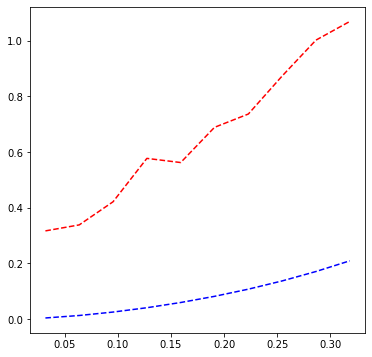

In [229]:
# Plotting data and estimating parameter values for maximum likelihood
np.random.seed(42)

func = lambda *args: - log_likelihood(*args)
initial = theta_true + 1e-1 * np.random.randn(len(theta_true))
soln = minimize(func, initial, args=(x, y, std))
print(soln.x)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.plot(x, y,'r--')
y_fit=np.sum([a*x**i for a, i in enumerate(soln.x)], axis=0)
ax.plot(x, y_fit,'b--')

In [257]:
initial_pos = soln.x + 1e-3* np.random.randn(32,len(theta_true))
nwalkers, ndim = initial_pos.shape
n_burn=1000
n_steps=5000

sampler = emcee.EnsembleSampler(nwalkers, ndim, \
                                log_posterior, args=(x , y, std, a_min, a_max))
state = sampler.run_mcmc(initial_pos, n_burn);
sampler.reset()
sampler.run_mcmc(state, n_steps);

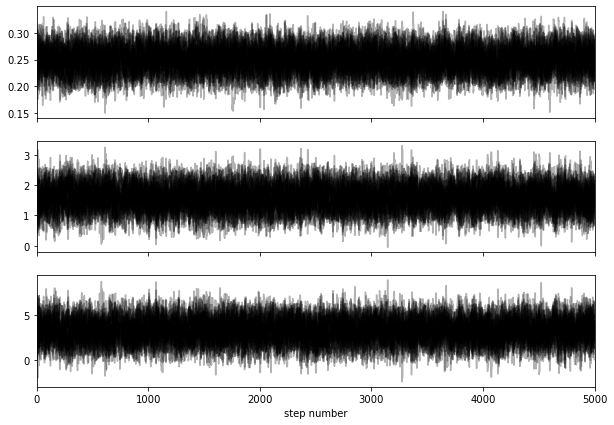

In [261]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
#labels = [f"a_{i}" in range(ndim)]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    #ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

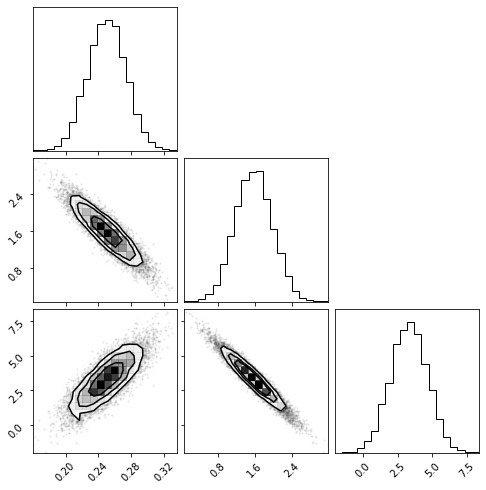

In [262]:
flat_samples = sampler.get_chain(discard=n_burn, thin=15, flat=True)
fig = corner.corner(flat_samples);